# Домашнее задание 2

Выполните следующие задания. Полученный после заполнения вашим кодом файл присылайте на почту kurnosovartem@gmail.com, следуя тем же правилам, что в первом задании.

In [1]:
import networkx as nx

### Задание 1
Построив соответствующую сеть и решив для неё задачу о максимальном потоке любым из [имеющихся в networkx алгоритмов](https://networkx.org/documentation/stable/reference/algorithms/flow.html), найдите паросочетание максимального размера в заданном неориентированном двудольном графе $G$ ниже. Убедитесь, что Ваш код проходит тест ниже.

In [2]:
k = 5
n = 20
G = nx.Graph()
G.add_nodes_from(range(2*n))
G.add_edges_from(
    (a, b + n) 
    for a,b in nx.random_regular_graph(k, n, 2020).edges()
)
# Построенный выше тестовый граф G — двудольный
# с номерами вершин в одной доле от 0 до n-1
# и в другой доле от n до 2*n-1

In [3]:
# В переменную M сохраните множество рёбер 
# наибольшего паросочетания в графе G
# Ребро — это tuple или set или frozenset,
# содержащее соответствующую пару вершин
M = set()

# Ваш код тут.
source = 's'
target = 't'
# Построим сеть с истоком в левой части и стоком в правой (все емкости = 1)
flow_G = nx.DiGraph()
flow_G.add_nodes_from([source, target])
flow_G.add_nodes_from(G.nodes())
for u in range(n):
    flow_G.add_edge(source, u, capacity=1)
for v in range(n, 2 * n):
    flow_G.add_edge(v, target, capacity=1)
for u, v in G.edges():
    flow_G.add_edge(u, v, capacity=1)

# Максимальный поток в таком случае достигается при максимальном количестве
# не пересекающихся путей от истока к стоку. Т.к. граф двудольный все пары вершин,
# образующих ребра являются паросочетанием.
max_flow, flow_dict = nx.maximum_flow(flow_G, source, target)
M = set()
for u in range(n):
    for v, flow in flow_dict[u].items():
        if flow > 0 and v >= n:
            M.add((u, v))

max_flow

15

In [4]:
# Это простая проверка того, что M образует паросочетание,
# и что его размер совпадает с эталонным
from functools import reduce
print(1 == len({
    2*len(M),
    len(reduce(lambda e1, e2: set(e1) | set(e2), M)),
    len(nx.bipartite.maximum_matching(G, range(n)))
}))

True


### Задание 2
Построив соответствующую сеть и решив для неё задачу о максимальном потоке, найдите максимально возможное количество не пересекающихся по внутренним **вершинам** путей между вершинами $s$ и $t$ в заданном неориентированном графе $G$. Убедитесь, что Ваш код проходит тест ниже.

In [5]:
def num_disjoint_paths(G, s, t):
    if s == t:
        return 0
    # Построим сеть с узлами соответствующими входам и выходам вершин
    # изначального не ориентированного графа. Пропускная способность ребер
    # соединяющих вход и выход одной вершины установим = 1 (кроме s и t). 
    # у ребер между вершинами установим пропускную способность = inf.
    flow_G = nx.DiGraph()
    INF = 10**10
    for v in G.nodes():
        vin = (v, 'in')
        vout = (v, 'out')
        capacity = INF if v in (s, t) else 1
        flow_G.add_edge(vin, vout, capacity=capacity)
    for u, v in G.edges():
        flow_G.add_edge((u, 'out'), (v, 'in'), capacity=INF)
        flow_G.add_edge((v, 'out'), (u, 'in'), capacity=INF)
    source = (s, 'out')
    target = (t, 'in')
    # Задача нахождения максимального потока решает поставленную
    flow_value, _ = nx.maximum_flow(flow_G, source, target)
    return flow_value


True
True


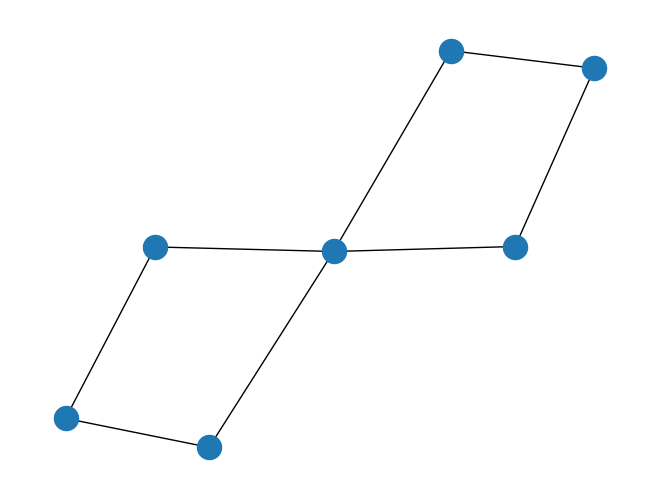

In [6]:
# Простые тесты, они должны проходиться при запуске непосредственно после предыдущей ячейки
G = nx.mycielski_graph(10)
s = 7
t = 700
print(
    num_disjoint_paths(G, s, t) 
    == 
    nx.node_connectivity(G, s, t)
)

G = nx.Graph()
edges = []
G.add_nodes_from([0,1,2,3,4,5,6])
for i in range(5):    
    edges.append((i, i + 1))
edges.append((2,5))
edges.append((2,6))
edges.append((0,6))
G.add_edges_from(edges)
nx.draw(G)
s = 0
t = 4
print(
    num_disjoint_paths(G, s, t)
    ==
    nx.node_connectivity(G, s, t)
)

### Задание 3
Построив поток в соответствующей сети, выберите из данного множества задач `tasks` такое подмножество, суммарная выгода выполнения задач которого максимальна. 

Словарь `prerequisites` содержит для каждой задачи перечень других задач, которые требуется решить перед началом её выполнения (если таковые есть). 

Словарь `profit` содержит информацию о выгоде решения каждой из задач. Выгоды — целочисленные, могут быть как положительные, так и отрицательные, и нулевые.

Также задано множество `compulsory` задач, которые нужно решить в обязательном порядке. Подумайте, и опишите в комментириях, как с минимальными усилиями интегрировать это в рассказанный на лекции алгоритм. Убедитесь, что Ваш код проходит тест ниже.

In [7]:
# Ниже приведён алгоритм решения задачи полным перебором,
# результат работы которого можно считать эталонным
from itertools import combinations

def brute_force_selection(tasks, prerequisites, profit, compulsory):
    best_profit = 0
    best_selection = set()
    for ss in range(1, len(tasks)):
        for c in combinations(tasks, ss):
            if any(t not in c for t in compulsory):
                continue
            for t in c:
                if t in prerequisites:
                    for p in prerequisites[t]:
                        if p not in c:
                            break
                    else:
                        continue
                    break
            else:
                current_profit = sum(profit[t] for t in c)
                if current_profit > best_profit:
                    best_profit = current_profit
                    best_selection = set(c)
    return best_selection

In [8]:
def flow_based_selection(tasks, prerequisites, profit, compulsory):
    source = 's'
    target = 't'
    # Положительные задачи соединяем с истоком, отрицательные со стоком.
    # Между зависимостями строим ребра бесконечной пропусной способности.
    G_flow = nx.DiGraph()
    G_flow.add_nodes_from([source, target])
    INF = 10**10
    for task in tasks:
        cap = weight = profit[task]
        if task in compulsory:
            # Обязательные задачи просто принудительно оставляем в "зависимости" источника
            cap = INF
        if cap > 0:
            G_flow.add_edge(source, task, capacity=cap)
        if weight < 0:
            G_flow.add_edge(task, target, capacity=-cap)
        G_flow.add_node(task)
    for task, prereq in prerequisites.items():
        for req in prereq:
            G_flow.add_edge(task, req, capacity=INF)
    _, (reachable, _) = nx.minimum_cut(G_flow, source, target)
    return {task for task in reachable if task in tasks}


In [9]:
# Простой тест, он должен проходиться при запуске непосредственно после выполнения предыдущей ячейки
import random
random.seed(2020)

tasks = set(range(1, 22))

ranges = [
    (1, len(tasks) // 3), 
    (len(tasks) // 3, 2 * len(tasks) // 3), 
    (2 * len(tasks) // 3, len(tasks))
]

prerequisites = {}
for ri, r in enumerate(ranges):
    if ri == 0:
        continue
    for t in range(*r):
        if random.randrange(1000)/1000 < 0.4:
            prerequisites[t] = set(random.sample(range(*ranges[ri-1]), 4))

profit = {
    task: random.randrange(-7, 15)
    for task in tasks
}

compulsory = set(random.sample(list(tasks), 2))

print(1 == len(set(
    sum(map(profit.get, 
        method(
            tasks, 
            prerequisites, 
            profit, 
            compulsory
        )
    ))
    for method in [
        brute_force_selection, 
        flow_based_selection
    ]
)))

True
